In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import tensorflow as tf
import pathlib
import PIL
import time
import zipfile
import random
from tensorflow import keras as ks
from tensorflow.keras.layers import *
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


In [2]:
sub=pd.read_csv("../input/animal-classification-challenge/sample_submission (4).csv", sep=",")

In [3]:
sub

,"id,label"
0,"ASG001dw7n_1.jpeg,1"
1,"ASG001dw7q_2.jpeg,0"
2,"ASG001dw7s_1.jpeg,0"
3,"ASG001dw7w_1.jpeg,1"
4,"ASG001dw7x_0.jpeg,0"
...,...
5994,"ASG001g7r0_1.jpeg,"
5995,"ASG001g7r0_2.jpeg,"
5996,"ASG001g7ry_1.jpeg,"
5997,"ASG001g7sb_0.jpeg,"


In [4]:
test=[]
id_=[]
diir="../input/animal-classification-challenge/test/test/"
for i in os.listdir(diir):
    id_.append(i)
    path=diir+i
    test.append(path)
    

In [5]:
train_zebra=[]
diir="../input/animal-classification-challenge/train_zebras/train_zebras/"
for i in os.listdir(diir):
    path=diir+i
    train_zebra.append(path)
    

In [6]:
train_ele=[]
diir="../input/animal-classification-challenge/train_elephants/train_elephants/"
for i in os.listdir(diir):
    path=diir+i
    train_ele.append(path)

In [7]:
z=[0 for i in range(len(train_zebra))]
e=[1 for i in range(len(train_ele))]
L=train_ele+train_zebra
l=e+z


In [8]:
len(l)

13999

In [9]:
train_df=pd.DataFrame({"path":L,"label":l})

In [10]:
train_df=train_df.sample(frac=1)

In [11]:
train_df

,path,label
3287,../input/animal-classification-challenge/train...,1
13958,../input/animal-classification-challenge/train...,0
10448,../input/animal-classification-challenge/train...,0
11516,../input/animal-classification-challenge/train...,0
1224,../input/animal-classification-challenge/train...,1
...,...,...
674,../input/animal-classification-challenge/train...,1
2782,../input/animal-classification-challenge/train...,1
2302,../input/animal-classification-challenge/train...,1
10302,../input/animal-classification-challenge/train...,0


In [12]:
train_datagenerator = ImageDataGenerator(
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rescale=1./255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=.2, 
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode='nearest',
    validation_split=0.1)

In [13]:
train_generator = train_datagenerator.flow_from_dataframe(
    train_df, 
    x_col='path', 
    y_col='label',
    target_size=(330, 330), 
    color_mode='rgb', 
    class_mode='raw', 
    batch_size=32, 
    shuffle=True, 
    seed=1,
    subset='training')
validation_generator = train_datagenerator.flow_from_dataframe(
    train_df , 
    x_col='path',
    y_col='label',
    target_size=(330, 330),
    color_mode='rgb', 
    class_mode='raw', 
    batch_size=4, 
    shuffle=True,
    seed=1, 
    subset='validation'
)

Found 12600 validated image filenames.
Found 1399 validated image filenames.


In [15]:
!git clone https://github.com/benihime91/leaf-disease-classification-kaggle
!pip install timm wandb --upgrade --quiet

Cloning into 'leaf-disease-classification-kaggle'...
remote: Enumerating objects: 3551, done.
remote: Counting objects: 100% (452/452), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 3551 (delta 310), reused 452 (delta 310), pack-reused 3099
Receiving objects: 100% (3551/3551), 93.28 MiB | 27.38 MiB/s, done.
Resolving deltas: 100% (2297/2297), done.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.0 requires protobuf==3.20.0, but you have protobuf 3.19.4 which is incompatible.
allennlp 2.10.0 requires wandb<0.13.0,>=0.10.0, but you have wandb 0.13.1 which is incompatible.


In [16]:
!wandb login a74f67fd5fae293e301ea8b6710ee0241f595a63 # [YOUR WANDB API KEY HERE]

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [17]:
import numpy as np
import uuid 
import os
import timm
import wandb
import pandas as pd
import albumentations as A

from fastai.vision.all import *
from fastai.callback.wandb import *

from torch.distributions.beta import Beta



ModuleNotFoundError: No module named 'src'

In [28]:
from extensions import *

In [31]:
# import sys
# sys.path.append("./leaf-disease-classification-kaggle/")

In [36]:
!pip install loguru

In [37]:
import sys
  
# adding src to the system path
sys.path.insert(0, '/home/USERNAME/PATH/TO/src')

In [39]:
# from src.model import _cut_model, _num_feats, _create_head

idx = uuid.uuid1()
idx = str(idx).split("-")[0]

set_seed(42)

In [41]:
class Config:
    fold_num    = 0
    num_classes = 2
#     csv_dir     = "./leaf-disease-classification-kaggle/data/fold_df.csv"
#     image_dir   = "/kaggle/input/cassava-leaf-disease-classification/train_images/"
    input_dims  = 330
    model_arch  = "efficientnet_b3a"
    project     = "kaggle-leaf-disease-fastai-runs" # [YOUR WANDB PROJECT NAME]
    
# init config
cfg = Config()

In [42]:
# class for albumentations transformations
# taken from : https://forums.fast.ai/t/albumentation-transformations-for-train-and-test-dataset/82642

class AlbumentationsTransform(RandTransform):
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)
    
def get_train_aug(): 
    return A.Compose([
        A.OneOf([
            A.RandomResizedCrop(cfg.input_dims, cfg.input_dims), 
            A.CenterCrop(cfg.input_dims, cfg.input_dims)
        ], p=0.5),
        A.Resize(cfg.input_dims, cfg.input_dims, p=1.0),
        A.HorizontalFlip(),
        A.ShiftScaleRotate(),
        A.OneOf([A.Flip(), A.Transpose(), A.IAAPerspective()]),
        A.RandomBrightnessContrast(0.1, 0.1, p=0.5),
        A.OneOf([A.CLAHE(), A.HueSaturationValue(0.2, 0.2, 0.2, p=0.5),], p=0.4),
        A.OneOf([A.CoarseDropout(), A.Cutout(), A.JpegCompression()], p=0.5),
    ])

def get_valid_aug():
    return A.Compose([A.Resize(cfg.input_dims, cfg.input_dims, p=1.0)], p=1.)

item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())

batch_tfms = [Normalize.from_stats(*imagenet_stats)]

In [49]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
#                 splitter=ColSplitter(),
                get_x=lambda o: o["path"],
                get_y=lambda o: o["label"],
                item_tfms=item_tfms,
                batch_tfms=batch_tfms)

In [50]:
from sklearn.model_selection import KFold
data             = train_df
# data["is_valid"] = [data.kfold[n] == cfg.fold_num for n in range(len(data))]

# shuffle the dataset
data = data.sample(frac=1).reset_index(drop=True, inplace=False)
data.head()

,path,label
0,../input/animal-classification-challenge/train_zebras/train_zebras/ASG001er7z_0.jpeg,0
1,../input/animal-classification-challenge/train_elephants/train_elephants/ASG00184j1_0.jpeg,1
2,../input/animal-classification-challenge/train_elephants/train_elephants/ASG0014m2q_0.jpeg,1
3,../input/animal-classification-challenge/train_zebras/train_zebras/ASG001ejyz_2.jpeg,0
4,../input/animal-classification-challenge/train_elephants/train_elephants/ASG0016tov_1.jpeg,1


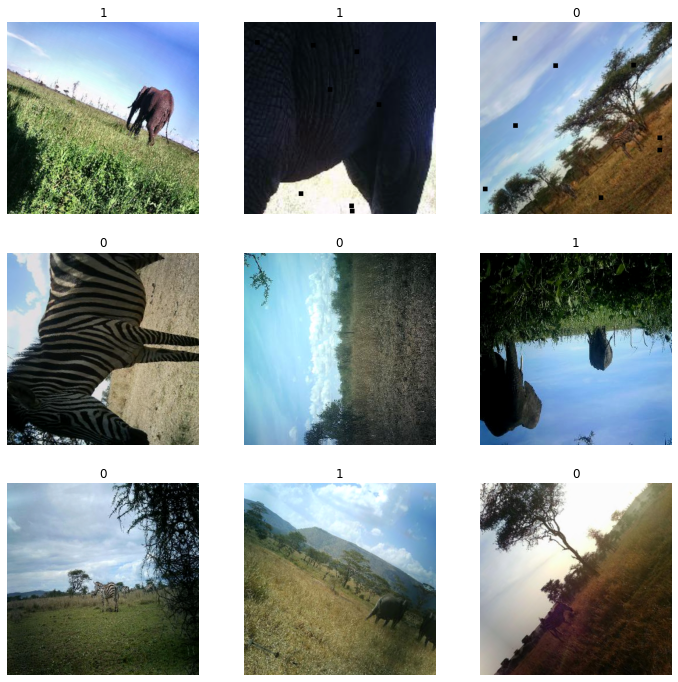

In [51]:
dls = dblock.dataloaders(train_df)

# Let's look at a batch of data to make sure everything looks alright:
dls.show_batch(figsize=(12,12))

In [65]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d( ... )
  (3): Dropout( ... )
  (4): Linear( ... )
  (5): ReLU( ... )
  (6): BatchNorm1d( ... )
  (7): Dropout( ... )
  (8): Linear( ... )
)

SyntaxError: invalid syntax (323906773.py, line 5)

In [76]:
Sequential(
   AdaptiveConcatPool2d(
    AdaptiveAvgPool2d (output_size=1),
    AdaptiveMaxPool2d(output_size=1)
  ),
  Flatten(full=False),
   BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
   Dropout (p=0.25, inplace=False),
   Linear(in_features=10, out_features=512, bias=False),
   ReLU(inplace=True),
   BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
   Dropout(p=0.5, inplace=False),
  (Linear(in_features=512, out_features=10, bias=False),))

NameError: name 'AdaptiveAvgPool2d' is not defined

In [ ]:
class TransferLearningModel(Module):
    """Transfer Learning with pre-trained encoder.
    Args:
        encoder    : a pre-trained model architecture like tf_efficientnet_b3
        num_classes: total number of output classes
        lin_ftrs   : number of Linear nodes before the final output layer
    """
    def __init__(self, encoder, num_classes = cfg.num_classes, lin_ftrs=512, cut=-2):
        # remove the classifier from the encoder which are
        # the final two layers of the encoder
        self.encoder = _cut_model(encoder, cut)
        
        # calculate output features of the cut encoder
        ftrs = _num_feats(self.encoder) * 2
        
        # create the head/decoder for the encoder
        self.decoder = _create_head(ftrs, num_classes, lin_ftrs)
        apply_init(self.decoder)
        
    def forward(self, xb):
        # 1. Feature extraction:
        feats = self.encoder(xb)
        
        # 2. Decoder (returns logits):
        logits = self.decoder(feats)
        return logits

In [ ]:
# import tensorflow_addons as tfa
# from keras.applications.vgg16 import VGG16
# from keras.models import Model
# from keras.layers import Dense
# from keras.layers import Flatten

# from tensorflow.keras.applications.resnet50 import ResNet50

# model = ResNet50(include_top=False, input_shape=(330, 330, 3))
# flat1 = Flatten()(model.layers[-1].output)
# class1 = Dense(1024, activation='relu')(flat1)
# class2 = Dense(512, activation='relu')(class1)
# class3 = Dense(256, activation='relu')(class2)
# output = Dense(2, activation='softmax')(class3)
# # define new model
# model = Model(inputs=model.inputs, outputs=output)
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['acc'])

In [ ]:
# batch_size=20
# FAST_RUN = False
# epochs=5 if FAST_RUN else 20
# history = model.fit_generator(
#     train_generator, 
#     epochs=epochs,
#     validation_data=validation_generator
# )

In [ ]:
# p=[]
# from PIL import Image
# for i in test:
#     img = np.array(Image.open(i).resize((330,330))).reshape((1, 330, 330 , 3))
#     out = model(img)
# #     print(out)
# #     print(tf.get_static_value(tf.math.argmax(out, axis=1)))
#     p.append(tf.get_static_value(tf.math.argmax(out, axis=1)))

# tf.get_static_value(tf.math.argmax(out, axis=1))
# p=[i[0] for i in p]
# submission=pd.DataFrame({"id":id_,"label":p})
# submission.to_csv("sub4.csv", index=False)